In [ ]:
from huggingface_hub import hf_hub_download

metadata = hf_hub_download(
    "rendeirolab/lazyslide-data",
    "TCGA_READ_survival.csv",
    repo_type="dataset",
    local_dir=".",
)

In [ ]:
import pandas as pd

metadata = pd.read_csv(metadata)
metadata.head(5)

,PATIENT_ID,AGE,AJCC_STAGING_EDITION,BIOPSY_SITE,DAYS_LAST_FOLLOWUP,DAYS_TO_BIRTH,DAYS_TO_DEATH,DISEASE_TYPE,ETHNICITY,ICD_10,...,SEX,VITAL_STATUS,YEAR_OF_DIAGNOSIS,OS_STATUS,OS_MONTHS,PROJECT_ID,PROJECT_NAME,PROJECT_STATE,FILE_ID,FILE_NAME
0,TCGA-AG-3601,68.0,6th,Rectum,0.0,-24837.0,NaN,Rectal Adenocarcinoma,NaN,C19,...,Male,Alive,2007.0,0:LIVING,0.000000,TCGA-READ,Rectal Adenocarcinoma,released,d76f3d2c-f30d-4592-a51d-620e17419222,TCGA-AG-3601-01Z-00-DX1.30ac783e-ba70-49ef-8be...
1,TCGA-AF-6136,72.0,7th,Rectum,232.0,-26490.0,NaN,Rectal Adenocarcinoma,NOT HISPANIC OR LATINO,C19,...,Female,Alive,2011.0,0:LIVING,24.342970,TCGA-READ,Rectal Adenocarcinoma,released,ec1f9ff4-f634-42fb-9c64-dee4950df4df,TCGA-AF-6136-01Z-00-DX1.a0e22964-b7b4-43ba-bfa...
2,TCGA-AH-6549,66.0,7th,Rectum,6.0,-24337.0,NaN,Rectal Adenocarcinoma,NaN,C20,...,Male,Alive,2010.0,0:LIVING,17.477004,TCGA-READ,Rectal Adenocarcinoma,released,1f07b827-255a-4d32-9eea-f2daff7bd937,TCGA-AH-6549-01Z-00-DX1.38ea40f7-4ebf-49cc-801...
3,TCGA-AG-A01Y,49.0,5th,Rectum,0.0,-18112.0,NaN,Rectal Adenocarcinoma,NaN,C20,...,Female,Alive,2004.0,0:LIVING,0.000000,TCGA-READ,Rectal Adenocarcinoma,released,b7c07212-1bc0-48b3-8b69-6adffa0fb08f,TCGA-AG-A01Y-01Z-00-DX1.3F49940B-3758-419B-89C...
4,TCGA-AG-3883,69.0,6th,Rectum,31.0,-25415.0,NaN,Rectal Adenocarcinoma,NaN,C20,...,Male,Alive,2008.0,0:LIVING,1.018397,TCGA-READ,Rectal Adenocarcinoma,released,2d8f32f9-bb04-46cd-8d63-91b591e9b8b3,TCGA-AG-3883-01Z-00-DX1.2a21ffb1-8a60-4424-b74...


In [ ]:
slides = snapshot_download(
    "rendeirolab/lazyslide-data",
    repo_type="dataset",
    local_dir="tcga_read",
    allow_patterns=["tcga_read/*.svs"],
)

In [ ]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

def wsi_feature_extraction(slide):

    from wsidata import open_wsi
    import lazyslide as zs

    wsi = open_wsi(s, attach_thumbnail=False)
    zs.pp.find_tissues(wsi)
    zs.pp.tile_tissues(wsi, 448, mpp=0.5, background_fraction=0.5)

    zs.tl.feature_extraction(wsi, "titan", pbar=False)
    zs.tl.feature_aggregation(wsi, "titan", encoder="titan")
    wsi.write()

cluster = SLURMCluster(
    queue="gpu",
    cores=8,
    processes=1,
    memory="10 GB",
    job_extra_directives=[
        "-q gpu",
        "--gres=gpu:h100pcie:1",
        "--time=1:00:00",
    ],
    worker_extra_args=["--resources GPU=1"],
    log_directory="./dask-logs",
)

client = Client(cluster)
cluster.scale(10)  # Get 10 workers, each with one H100 to run

futures = [
    client.submit(wsi_feature_extraction, f"slides/{slide}", resources={"GPU": 1})
    for slide in matadata["FILE_NAME"]
]

In [ ]:
slides = snapshot_download(
    "rendeirolab/lazyslide-data",
    repo_type="dataset",
    local_dir="tcga_read",
    allow_patterns=["tcga_read/*.svs"],
)

In [ ]:
import anndata as ad

titan_features = hf_hub_download(
    "rendeirolab/lazyslide-data",
    "TCGA_READ_subset_TITAN.h5ad",
    repo_type="dataset",
    local_dir=".",
)

adata = ad.read_h5ad(titan_features)

In [ ]:
adata

AnnData object with n_obs × n_vars = 50 × 768
    obs: 'PATIENT_ID', 'AGE', 'AJCC_STAGING_EDITION', 'BIOPSY_SITE', 'DAYS_LAST_FOLLOWUP', 'DAYS_TO_BIRTH', 'DAYS_TO_DEATH', 'DISEASE_TYPE', 'ETHNICITY', 'ICD_10', 'MORPHOLOGY', 'OTHER_PATIENT_ID', 'PATH_M_STAGE', 'PATH_N_STAGE', 'PATH_STAGE', 'PATH_T_STAGE', 'PRIMARY_DIAGNOSIS', 'PRIMARY_SITE_PATIENT', 'PRIOR_MALIGNANCY', 'PRIOR_TREATMENT', 'RACE', 'SEX', 'VITAL_STATUS', 'YEAR_OF_DIAGNOSIS', 'OS_STATUS', 'OS_MONTHS', 'PROJECT_ID', 'PROJECT_NAME', 'PROJECT_STATE', 'FILE_ID', 'FILE_NAME', 'slide_path'

In [ ]:
adata.obs["status"] = (
    adata.obs["OS_STATUS"].map({"0:LIVING": 0, "1:DECEASED": 1}).astype(bool)
)

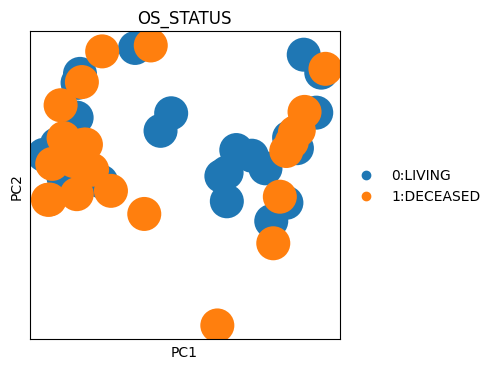

In [ ]:
import scanpy as sc

sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pl.pca(adata, color="OS_STATUS")

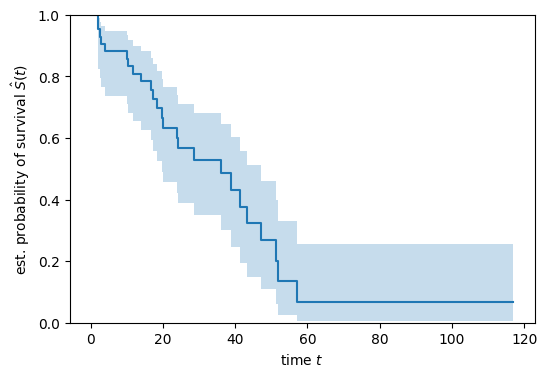

In [ ]:
import matplotlib.pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    adata.obs["status"], adata.obs["OS_MONTHS"], conf_type="log-log"
)
with plt.rc_context({"figure.figsize": (6, 4)}):
    plt.step(time, survival_prob, where="post")
    plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    plt.ylim(0, 1)
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")

In [ ]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    adata.X,
    adata.obs[["status", "OS_MONTHS"]].to_records(index=False),
    test_size=0.2,
    stratify=adata.obs["status"],
    random_state=10,
)

model = CoxnetSurvivalAnalysis(
    l1_ratio=0.9, alpha_min_ratio=0.01, n_alphas=100, fit_baseline_model=True
)
model.fit(X_train, y_train)
s = model.score(X_test, y_test)
print("cindex:", model.score(X_test, y_test))

cindex: 0.6428571428571429


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define a model
class CoxMLP(nn.Module):
    def __init__(self, in_features, hidden_dim=32, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)  # single risk score

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)  # risk score, no activation

In [ ]:
X_train, X_test, E_train, E_test, T_train, T_test = train_test_split(
    adata.X,
    adata.obs["status"].to_numpy(),
    adata.obs["OS_MONTHS"].to_numpy(),
    test_size=0.2,
    stratify=adata.obs["status"],
    random_state=10,
)

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
E_train = torch.tensor(E_train)
E_test = torch.tensor(E_test)
T_train = torch.tensor(T_train)
T_test = torch.tensor(T_test)

In [ ]:
from torchsurv.loss import cox
from torchsurv.metrics.cindex import ConcordanceIndex

# The titan features size is 768
model = CoxMLP(768)
torch.manual_seed(0)

# Trained for 10 epoches
for _ in range(10):
    estimate = model(X_train)
    loss = cox.neg_partial_log_likelihood(estimate, E_train, T_train)
    loss.backward()

# Evaluation
with torch.no_grad():
    log_hz = model(X_test)
    cindex = ConcordanceIndex()
    print(cindex(log_hz, E_test, T_test))

tensor(0.8571, dtype=torch.float64)


/home/runner/work/lazyslide-tutorials/lazyslide-tutorials/.venv/lib/python3.12/site-packages/torchsurv/loss/cox.py:222: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(
